In [57]:
import importlib
common_utils = importlib.reload(utils23_logreg_binning)
import sys
import datetime
sys.path.insert(0, "/Users/xulinchen/Documents/Dolplayground/Dolgit/Common_Utils")
import common_utils
common_utils.comfortable_display()

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import re
import os
import datetime
import importlib

In [58]:
#Load customised functions
import config
import utils0_data_loading_cleaning
import utils1_target_creation
import utils21_feature_distribution
import utils22_feature_process
import utils23_logreg_binning
import utils3_train_val_test
import utils4_train_eval_model

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Load and clean the data
df = utils0_data_loading_cleaning.data_load_clean(config.dir_path, 
                                                  config.file_name)
#Create target
df = utils1_target_creation.target_creation(df)

#Feature processing
# df = utils22_feature_process.feature_process(df)

---- Target Creation started ----
Number of bads is :  11
Number of goods is :  895
bad rate is : 1.21%
---- Target Creation completed ----




In [59]:
df['Acquired_ym'] = pd.to_datetime(df['Acquired']).dt.strftime('%Y-%m')
df['Acquired_ym'].value_counts()                                 

2018-12    314
2019-08    155
2019-05     61
2019-10     59
2019-03     54
2019-02     42
2019-07     41
2019-09     40
2019-06     38
2019-01     36
2019-04     36
2018-11     13
2019-11     11
2019-12      6
Name: Acquired_ym, dtype: int64

### Logistic Regress Feature Engineering Process (Also called 'Binning')
High level idea is binning is a process of groupping similar values of a feature together but preserve as much information value as possible

STEP 1.1 - FINECLASS - turn values of a feature into groups
- s : df[var] any type of feature (continuous/categorical/mixed type)
- s_num, s_cat : the numeric and non_numeric part of df[var], a subset of the series. missing and special values are counted as non-numeric
- num_bin_edges_fc, cat_bin_values_fc: numpy arrays of numeric bin edges and categorical unique values
- s_num_fc: fineclass 20 bins. the result of pd.qcut. type is string created based on categorical Interval
- s_cat_fc: same as s_cat, with missing and special values being replaced by their user-defined labels
- s_fc: stack s_num_fc and s_cat_fc together
    
STEP 1.2 - FINECLASS EVALUATION - Produce WOE IV stats
- eval_df_summary_fc: creates the woe/iv summary dataframe based on s_fc and target

STEP 2.1 - COARSECLASS - customize the binning based on observation from eval_df_summary
- num_bin_edges_cc: defined based on num_bin_edges_fc - group zerobad with the next bin automatically or input user defined grouping -> still a numpy array
- cat_bin_values_cc: defined based on cat_bin_values_fc - user defined grouping -> if number of groups are manageable (i.e. <=20) a dictionary or a numpy array of list of grouped values; otherwise categorical encoding with smoothing is recommended.
- s_num_cc: use s_num and num_bin_edges_cc as inputs. the result of pd.qcut.
- c_cat_cc: use s_cat_fc and cat_bin_values_cc as inputs
- s_cc: stack s_num_cc and s_cat_cc together

STEP 2.2 - COARSECLASS EVALUATION - Produce WOE IV stats
- eval_df_summary_cc: creates the woe/iv summary dataframe based on s_cc and target

STEP 3 - WOE ENCODING based on COARSECLASS
- s_cc_woe: pandas series. Map s_cc mapped to woe based on eval_df_summary_cc

### Utilities about coarse class for numeric features
- num_cc_edges_nonzerobad: keep the max bin edges of the bins having >0 bad. add min in the front, and when the last one or more bins has 0 bad, group it/them with the last bin with >0 bad.
- num_cc_edges_woe_enforce_monotonicity: based on correlation between feature and target, find the non-monotonic bins (woe_diff), compare woe_diff_abs with the neighbouring bins of the non-monotonic bin, choose group with the bin with a closer woe
- num_cc_edges_custom: input customised lists of group indices to group the corresponding bins. indices apply to num edges (num_cc_edges_fc or num_cc_edges_cc). 

### Utilities about coarse class for categorical features
- cat_cc: input customised lists of group indices to group the corresponding bins. indices apply to cat_bin_values_fc
- cat_high_cardi_encoding: smoothing woe encoding designed for high cardinality feature. noise is added to smooth the observed woe

### To improve or think about
- coarse class: 
    - when there are two bins left, one has 0 bad -- could be low volume so no bad, otherwise, should be a good case.

In [ ]:
# df[var] -> <split_num_cat> -> s_num and s_cat

In [1142]:
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

### Example of categorical variable

#### STEP 1 - FINECLASS and EVALUATION

0 rows in s_num 
906 rows in s_cat
num bin edges:  []
cat values:  ['Business purposes' 'Car' 'Caravan' 'Consolidate existing debts'
 'Electronic goods (eg. Computer, TV, Audio)' 'Holiday'
 'Home improvements' 'House deposit' 'Motorbike' 'Other'
 'Pay off credit cards' 'Pay off loan from relative or friend' 'Repairs'
 'Tax bill' 'Wedding expenses']
Fineclass
IV is 0.45448044698647727
total number of rows match


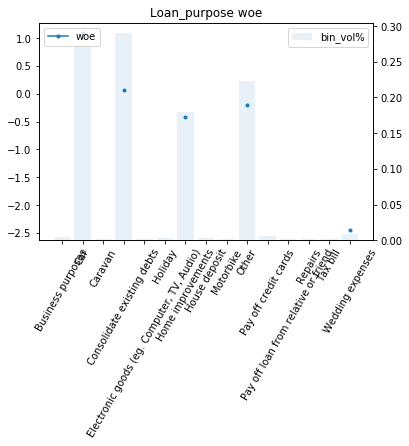

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,Business purposes,4.0,0.0,NaN,4.0,0.004469,0.000000,0.004415,NaN,NaN,0.000000,NaN
1,Car,244.0,1.0,NaN,245.0,0.272626,0.090909,0.270419,1.098240,5.497168,0.004082,0.199568
2,Caravan,1.0,0.0,NaN,1.0,0.001117,0.000000,0.001104,NaN,NaN,0.000000,NaN
3,Consolidate existing debts,260.0,3.0,NaN,263.0,0.290503,0.272727,0.290287,0.063141,4.462069,0.011407,0.001122
4,"Electronic goods (eg. Computer, TV, Audio)",2.0,0.0,NaN,2.0,0.002235,0.000000,0.002208,NaN,NaN,0.000000,NaN
5,Holiday,3.0,0.0,NaN,3.0,0.003352,0.000000,0.003311,NaN,NaN,0.000000,NaN
6,Home improvements,160.0,3.0,NaN,163.0,0.178771,0.272727,0.179912,-0.422367,3.976562,0.018405,0.039684
7,House deposit,3.0,0.0,NaN,3.0,0.003352,0.000000,0.003311,NaN,NaN,0.000000,NaN
8,Motorbike,2.0,0.0,NaN,2.0,0.002235,0.000000,0.002208,NaN,NaN,0.000000,NaN
9,Other,199.0,3.0,NaN,202.0,0.222346,0.272727,0.222958,-0.204236,4.194693,0.014851,0.010290


In [60]:
var = 'Loan_purpose'
# var = 'Market'

target = 'target'

#Fine class
s_num, s_cat = utils23_logreg_binning.split_num_cat(df[var])

s_num_fc, num_bin_edges_fc = utils23_logreg_binning.num_fc(s_num, bin_num_fineclass =20)
print('{} rows in s_num \n{} rows in s_cat'.format(len(s_num), len(s_cat)))
print('num bin edges: ', num_bin_edges_fc)

s_cat_fc, cat_bin_values_fc = utils23_logreg_binning.cat_fc(s_cat)
print('cat values: ', cat_bin_values_fc)

s_fc = utils23_logreg_binning.combine_num_cat_fc(s_num_fc, s_cat_fc)

eval_df_summary_fc = utils23_logreg_binning.bin_woe_iv(s_fc, df[target])
    
eval_df_summary_fc

#### STEP 2 - COARSECLASS and EVALUATION

input bin groups  [[0, 1, 2], [3, 4], [5, 6]]
output bin values  ['A, A*, A-Sec' 'B, C' 'D, E']
Custom Coarseclass - group categorical bins
IV is 1.888717960966924
total number of rows match


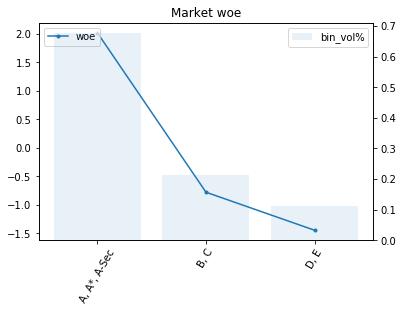

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,"A, A*, A-Sec",612.0,1.0,NaN,613.0,0.683799,0.090909,0.676600,2.017804,6.416732,0.001631,1.196335
1,"B, C",187.0,5.0,NaN,192.0,0.208939,0.454545,0.211921,-0.777258,3.621671,0.026042,0.190900
2,"D, E",96.0,5.0,NaN,101.0,0.107263,0.454545,0.111479,-1.444018,2.954910,0.049505,0.501483


In [47]:
# Categorical coarse classing - Manual group categorical bins (Recommended for features with <10 bins)
s_cat_cc, cat_bin_values_cc = utils23_logreg_binning.cat_cc(s_cat, cat_bin_values = cat_bin_values_fc, \
                                                            cat_bin_values_groups = [[0, 1, 2], [3, 4], [5, 6]])

s_cc = utils23_logreg_binning.combine_num_cat_fc(s_num_fc, s_cat_cc)

eval_df_summary_cc = utils23_logreg_binning.bin_woe_iv(s_cc, df[target], desc = 'Custom Coarseclass - group categorical bins')

eval_df_summary_cc

In [61]:
#Coarse Class - modify woe for zero bad bin (Recommended for high cardinality features)
eval_df_summary_cc = utils23_logreg_binning.cc_cat_zerobad_lowvolwoesmooth(cat_bin_values = cat_bin_values_fc, \
                                                                           eval_df_summary = eval_df_summary_fc, \
                                                                           min_samples_leaf=20, smoothing=10)
eval_df_summary_cc

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv,smoothing_factor
0,Business purposes,4.0,0.0,NaN,4.0,0.004469,0.000000,0.004415,0.000000,NaN,0.000000,NaN,0.167982
1,Car,244.0,1.0,NaN,245.0,0.272626,0.090909,0.270419,1.098240,5.497168,0.004082,0.199568,1.000000
2,Caravan,1.0,0.0,NaN,1.0,0.001117,0.000000,0.001104,0.000000,NaN,0.000000,NaN,0.130108
3,Consolidate existing debts,260.0,3.0,NaN,263.0,0.290503,0.272727,0.290287,0.063141,4.462069,0.011407,0.001122,1.000000
4,"Electronic goods (eg. Computer, TV, Audio)",2.0,0.0,NaN,2.0,0.002235,0.000000,0.002208,0.000000,NaN,0.000000,NaN,0.141851
5,Holiday,3.0,0.0,NaN,3.0,0.003352,0.000000,0.003311,0.000000,NaN,0.000000,NaN,0.154465
6,Home improvements,160.0,3.0,NaN,163.0,0.178771,0.272727,0.179912,-0.422367,3.976562,0.018405,0.039684,0.999999
7,House deposit,3.0,0.0,NaN,3.0,0.003352,0.000000,0.003311,0.000000,NaN,0.000000,NaN,0.154465
8,Motorbike,2.0,0.0,NaN,2.0,0.002235,0.000000,0.002208,0.000000,NaN,0.000000,NaN,0.141851
9,Other,199.0,3.0,NaN,202.0,0.222346,0.272727,0.222958,-0.204236,4.194693,0.014851,0.010290,1.000000


#### STEP 3 - WOE ENCODING based on COARSECLASS

In [67]:
#for high cardinality feature, s_cc is not created and changes were only made to woe. so assign s_fc to s_cc
if s_cc is None or s_cc.name!=var:
    s_cc = s_fc

#convert s_cc to woe
s_cc_woe = utils23_logreg_binning.cc_to_woe(s_cc, eval_df_summary_cc)

s_cc_woe

woe encoding {'Business purposes': 0.0, 'Car': 1.098239779630906, 'Caravan': 0.0, 'Consolidate existing debts': 0.06314089686916755, 'Electronic goods (eg. Computer, TV, Audio)': 0.0, 'Holiday': 0.0, 'Home improvements': -0.42236665872799517, 'House deposit': 0.0, 'Motorbike': 0.0, 'Other': -0.20423590687343302, 'Pay off credit cards': 0.0, 'Pay off loan from relative or friend': 0.0, 'Repairs': 0.0, 'Tax bill': 0.0, 'Wedding expenses': -0.5678129412449616}


0     -0.204236
1     -0.204236
2      1.098240
3     -0.422367
4     -0.204236
         ...   
901    0.063141
902    0.063141
903    1.098240
904    0.063141
905    0.063141
Name: Loan_purpose_woe, Length: 906, dtype: float64

### Example of numeric variable

#### STEP 1 - FINECLASS and EVALUATION

num of bins is  16
906 rows in s_num 
0 rows in s_cat
num bin edges:  [-0.001   0.0674  0.0832  0.0936  0.109   0.125   0.141   0.158   0.174
  0.195   0.211   0.228   0.245   0.299   0.37    0.535   1.    ]
cat values:  []
Fineclass
IV is 1.8142556302368862
total number of rows match


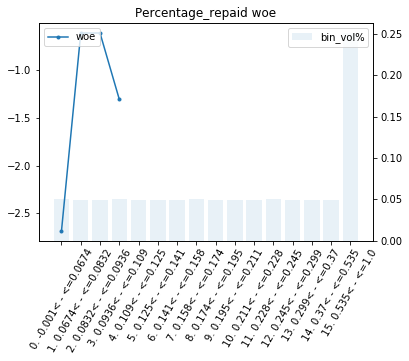

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,0. -0.001< - <=0.0674,39.0,7.0,0,46.0,0.043575,0.636364,0.050773,-2.681277,1.717651,0.152174,1.589429
1,1. 0.0674< - <=0.0832,44.0,1.0,1,45.0,0.049162,0.090909,0.049669,-0.614739,3.784190,0.022222,0.025664
2,2. 0.0832< - <=0.0936,44.0,1.0,2,45.0,0.049162,0.090909,0.049669,-0.614739,3.784190,0.022222,0.025664
3,3. 0.0936< - <=0.109,44.0,2.0,3,46.0,0.049162,0.181818,0.050773,-1.307886,3.091042,0.043478,0.173499
4,4. 0.109< - <=0.125,45.0,0.0,4,45.0,0.050279,0.000000,0.049669,NaN,NaN,0.000000,NaN
5,5. 0.125< - <=0.141,45.0,0.0,5,45.0,0.050279,0.000000,0.049669,NaN,NaN,0.000000,NaN
6,6. 0.141< - <=0.158,45.0,0.0,6,45.0,0.050279,0.000000,0.049669,NaN,NaN,0.000000,NaN
7,7. 0.158< - <=0.174,46.0,0.0,7,46.0,0.051397,0.000000,0.050773,NaN,NaN,0.000000,NaN
8,8. 0.174< - <=0.195,45.0,0.0,8,45.0,0.050279,0.000000,0.049669,NaN,NaN,0.000000,NaN
9,9. 0.195< - <=0.211,45.0,0.0,9,45.0,0.050279,0.000000,0.049669,NaN,NaN,0.000000,NaN


In [36]:
# var = 'Borrower_rate'
# var = 'Transaction_price'
# var = 'Market'
# var = 'Days_in_arrears'
var = 'Percentage_repaid'
target = 'target'

s_num, s_cat = utils23_logreg_binning.split_num_cat(df[var])

s_num_fc, num_bin_edges_fc = utils23_logreg_binning.num_fc(s_num, bin_num_fineclass =20)
print('{} rows in s_num \n{} rows in s_cat'.format(len(s_num), len(s_cat)))
print('num bin edges: ', num_bin_edges_fc)

s_cat_fc, cat_bin_values_fc = utils23_logreg_binning.cat_fc(s_cat)
print('cat values: ', cat_bin_values_fc)

s_fc = utils23_logreg_binning.combine_num_cat_fc(s_num_fc, s_cat_fc)

eval_df_summary_fc = utils23_logreg_binning.bin_woe_iv(s_fc, df[target])
eval_df_summary_fc

#### STEP 2 - COARSECLASS and EVALUATION

Coarseclass Group 0 Bad bins
IV is 2.6901533874172134
total number of rows match


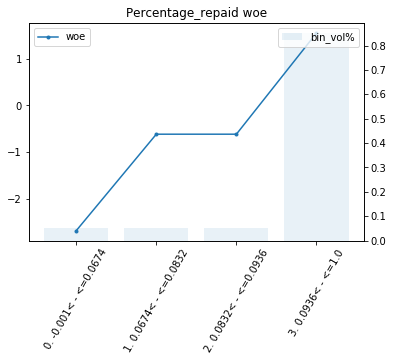

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,0. -0.001< - <=0.0674,39.0,7.0,0,46.0,0.043575,0.636364,0.050773,-2.681277,1.717651,0.152174,1.589429
1,1. 0.0674< - <=0.0832,44.0,1.0,1,45.0,0.049162,0.090909,0.049669,-0.614739,3.784190,0.022222,0.025664
2,2. 0.0832< - <=0.0936,44.0,1.0,2,45.0,0.049162,0.090909,0.049669,-0.614739,3.784190,0.022222,0.025664
3,3. 0.0936< - <=1.0,768.0,2.0,3,770.0,0.858101,0.181818,0.849890,1.551714,5.950643,0.002597,1.049397


In [37]:
# Numeric coarse classing - group 0 Bad bins
num_bin_edges_cc = utils23_logreg_binning.num_cc_edges_nonzerobad(s_num, num_bin_edges_fc, eval_df_summary_fc)
s_num_cc = utils23_logreg_binning.num_cc(s_num, num_bin_edges_cc)

s_cc = utils23_logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)

eval_df_summary_cc = utils23_logreg_binning.bin_woe_iv(s_cc, df[target], desc = 'Coarseclass Group 0 Bad bins')
eval_df_summary_cc

feature and target correlation is -0.10136656807414093, woe should increase as feature increase
input bin edges :  [-0.001   0.0674  0.0832  0.0936  1.    ] 
 dropping index [2]
output bin edges :  [-0.001   0.0674  0.0936  1.    ]
Automatic Coarseclass group non-monotonic bins
IV is 2.690153387417213
total number of rows match


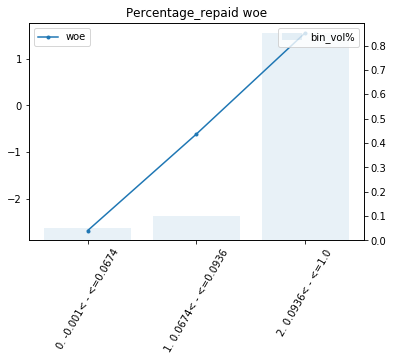

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,0. -0.001< - <=0.0674,39.0,7.0,0,46.0,0.043575,0.636364,0.050773,-2.681277,1.717651,0.152174,1.589429
1,1. 0.0674< - <=0.0936,88.0,2.0,1,90.0,0.098324,0.181818,0.099338,-0.614739,3.784190,0.022222,0.051327
2,2. 0.0936< - <=1.0,768.0,2.0,2,770.0,0.858101,0.181818,0.849890,1.551714,5.950643,0.002597,1.049397


In [38]:
# Numeric coarse classing - Automatic group non-monotonic bins
num_bin_edges_cc = utils23_logreg_binning.num_cc_edges_woe_enforce_monotonicity(s_num, df[target], num_bin_edges = num_bin_edges_cc, eval_df_summary = eval_df_summary_cc)

s_num_cc = utils23_logreg_binning.num_cc(s_num, num_bin_edges_cc)

s_cc = utils23_logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)

eval_df_summary_cc = utils23_logreg_binning.bin_woe_iv(s_cc, df[target], desc = 'Automatic Coarseclass group non-monotonic bins')

eval_df_summary_cc

feature and target correlation is -0.10136656807414093, woe should increase as feature increase
input bin edges :  [-0.001   0.0674  0.0936  1.    ] 
 dropping index []
output bin edges :  [-0.001   0.0674  0.0936  1.    ]
Automatic Coarseclass group non-monotonic bins
IV is 2.690153387417213
total number of rows match


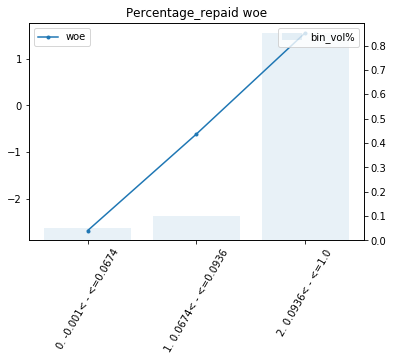

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,0. -0.001< - <=0.0674,39.0,7.0,0,46.0,0.043575,0.636364,0.050773,-2.681277,1.717651,0.152174,1.589429
1,1. 0.0674< - <=0.0936,88.0,2.0,1,90.0,0.098324,0.181818,0.099338,-0.614739,3.784190,0.022222,0.051327
2,2. 0.0936< - <=1.0,768.0,2.0,2,770.0,0.858101,0.181818,0.849890,1.551714,5.950643,0.002597,1.049397


In [39]:
# Numeric coarse classing - Automatic group non-monotonic bins - Round 2
num_bin_edges_cc = utils23_logreg_binning.num_cc_edges_woe_enforce_monotonicity(s_num, df[target], num_bin_edges = num_bin_edges_cc, eval_df_summary = eval_df_summary_cc)

s_num_cc = utils23_logreg_binning.num_cc(s_num, num_bin_edges_cc)

s_cc = utils23_logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)

eval_df_summary_cc = utils23_logreg_binning.bin_woe_iv(s_cc, df[target], desc = 'Automatic Coarseclass group non-monotonic bins')

eval_df_summary_cc

input bin edges :  [-0.001   0.0674  0.0936  1.    ] 
 dropping  [0.0936]
output bin edges :  [-0.001   0.0674  1.    ]
Manual Coarseclass group non-monotonic bins
IV is 2.1626837873785387
total number of rows match


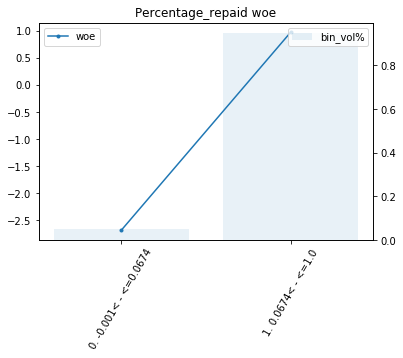

,feat,N_good,N_bad,feat_num_index,N_count,dist_good,dist_bad,bin_count_perc,woe,logodds,p_bad,iv
0,0. -0.001< - <=0.0674,39.0,7.0,0,46.0,0.043575,0.636364,0.050773,-2.681277,1.717651,0.152174,1.589429
1,1. 0.0674< - <=1.0,856.0,4.0,1,860.0,0.956425,0.363636,0.949227,0.967048,5.365976,0.004651,0.573254


In [40]:
# Numeric coarse classing - Manual group non-monotonic bins
num_bin_edges_cc = utils23_logreg_binning.num_cc_edges_custom(num_bin_edges_cc, [[1, 2]])

s_num_cc = utils23_logreg_binning.num_cc(s_num, num_bin_edges_cc)

s_cc = utils23_logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)

eval_df_summary_cc = utils23_logreg_binning.bin_woe_iv(s_cc, df[target], desc = 'Manual Coarseclass group non-monotonic bins')

eval_df_summary_cc

#### STEP 3 - WOE ENCODING based on COARSECLASS

In [42]:
s_cc = utils23_logreg_binning.combine_num_cat_fc(s_num_cc, s_cat_fc)

s_cc_woe = utils23_logreg_binning.cc_to_woe(s_cc, eval_df_summary_cc)

s_cc_woe

woe encoding {'0. -0.001< - <=0.0674': -2.6812769484021515, '1. 0.0674< - <=1.0': 0.9670475695453666}


0     -2.681277
1      0.967048
2      0.967048
3     -2.681277
4     -2.681277
         ...   
901    0.967048
902    0.967048
903   -2.681277
904   -2.681277
905   -2.681277
Name: Percentage_repaid_woe, Length: 906, dtype: float64